In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Import the data

In [3]:
data = pd.read_csv("Echantillons de données-20231125\\Danube ammonium level Time Series.csv", sep = ";", index_col="Months")
data

,Ammonium
Months,
01/01/1996,"0,253333"
01/02/1996,"0,218889"
01/03/1996,"0,242"
01/04/1996,"0,134545"
01/05/1996,"0,113333"
...,...
01/08/2017,"0,031222"
01/09/2017,"0,045875"
01/10/2017,"0,032474"


In [4]:
data['Ammonium'] = data['Ammonium'].apply(lambda x: str(x).split(',')[-1])
data['Ammonium'] = data['Ammonium'].astype(int)
data

,Ammonium
Months,
01/01/1996,253333
01/02/1996,218889
01/03/1996,242
01/04/1996,134545
01/05/1996,113333
...,...
01/08/2017,31222
01/09/2017,45875
01/10/2017,32474


## Plot of the Time Series

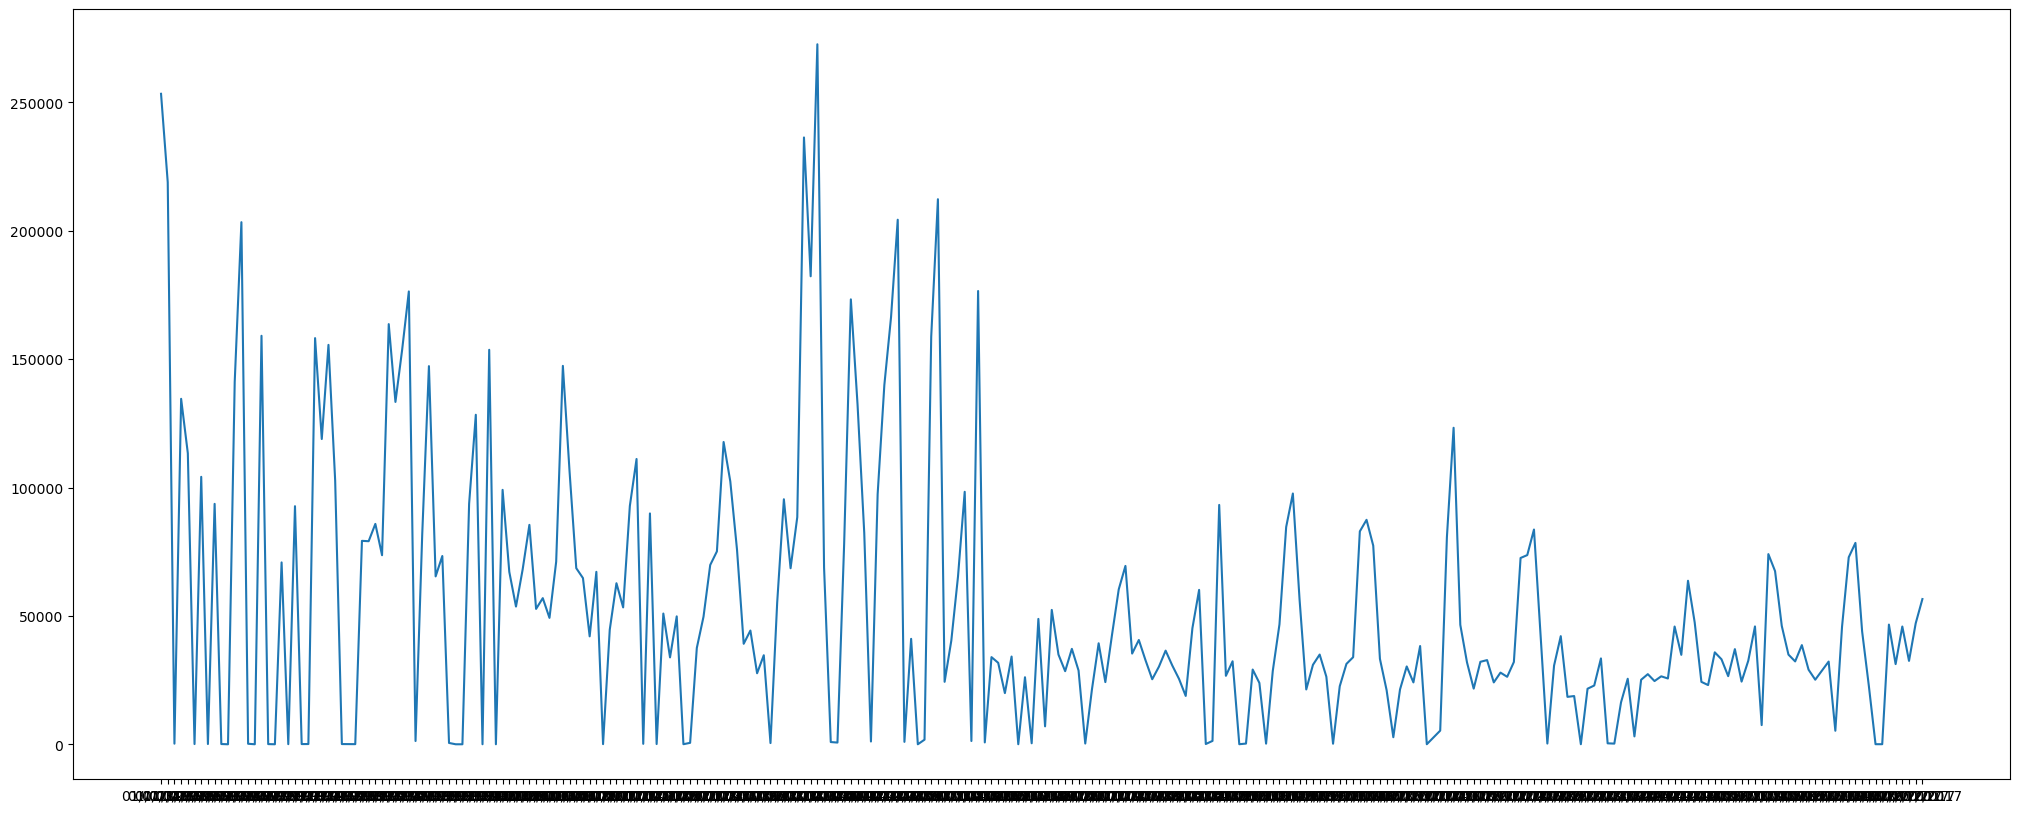

In [5]:
plt.figure(figsize=(25,10))
plt.plot(data['Ammonium'])

### Split the data

In [6]:
training_set = data.iloc[:252]
test_set = data.iloc[-13:]

### Scaling the data

In [7]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

### Préparation de la donnée

In [8]:
#representation des donnees sous 2 colonnes: x qui represente les entree et y qui repreente les sorties correspondantes
#La valeur de sortie correspondante a une entree est l'élément à l'étape temporelle suivante.

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

In [10]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [11]:
n_steps = 1
features = 1
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [12]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [13]:
X_test, y_test = split_sequence(test_set_scaled, 1)
# Reshaping X_test for model
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model 1

Reloading Tuner from hyperparameter_tuning\simple_rnn_tuning\tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000002C92761FD00>

Epoch 1/20


7/7 [==============================] - 1s 36ms/step - loss: 0.1027 - mae: 0.2379 - val_loss: 0.0155 - val_mae: 0.1043
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0771 - mae: 0.1983 - val_loss: 0.0094 - val_mae: 0.0795
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0592 - mae: 0.1727 - val_loss: 0.0056 - val_mae: 0.0563
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0471 - mae: 0.1552 - val_loss: 0.0042 - val_mae: 0.0457
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0404 - mae: 0.1457 - val_loss: 0.0052 - val_mae: 0.0579
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0390 - mae: 0.1475 - val_loss: 0.0069 - val_mae: 0.0703
Epoch 7/20
7/7 [===============

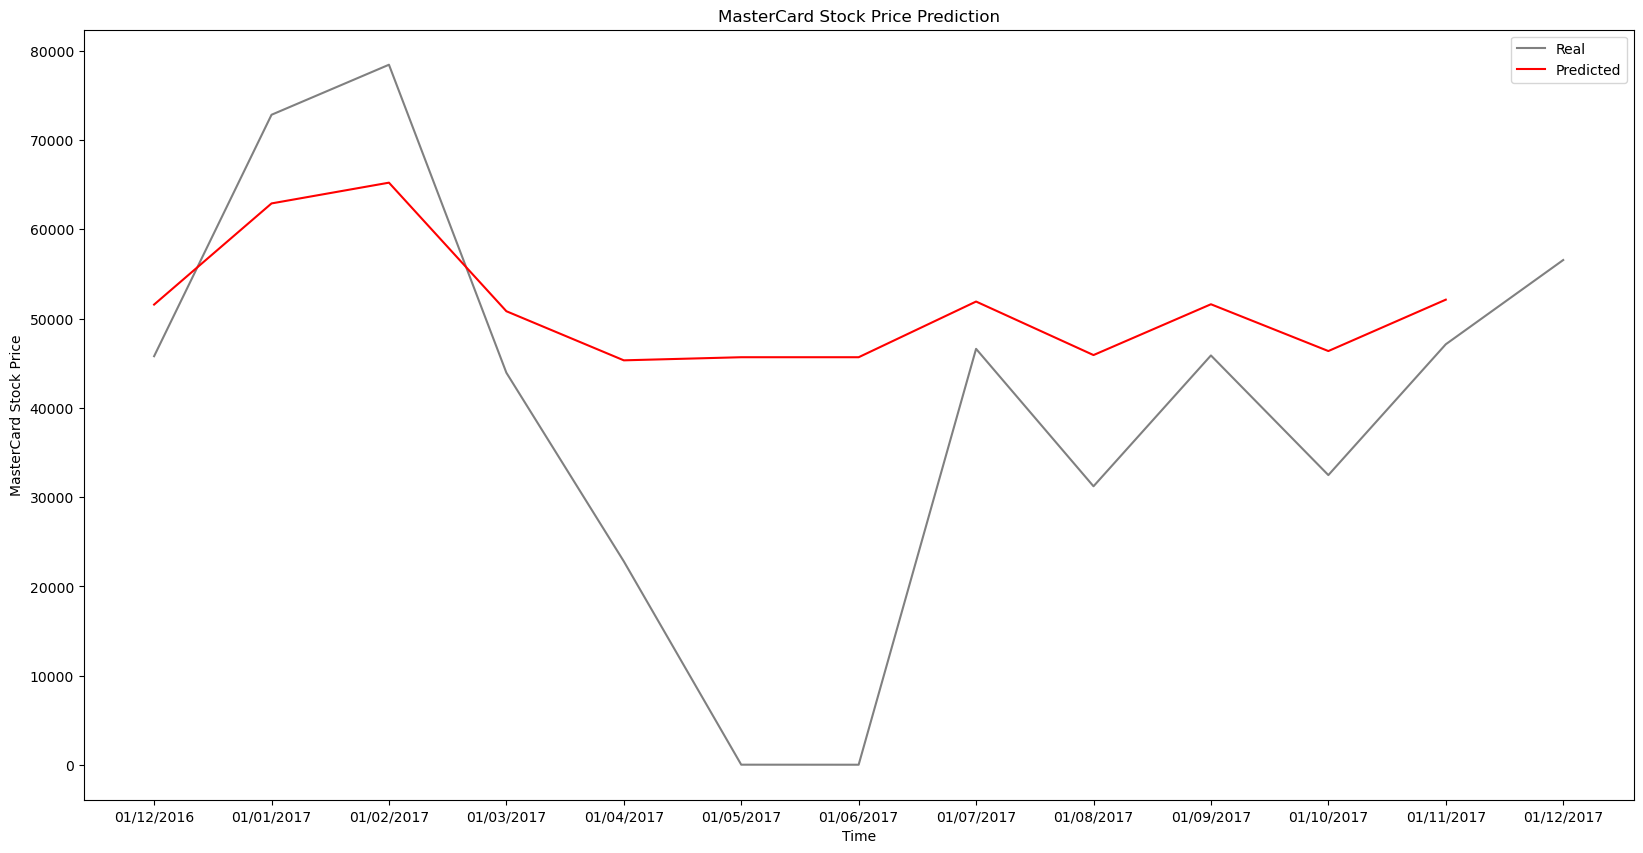

The root mean squared error is 21451.34.


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Define your RNN model
def build_model(hp):
    model = Sequential()
    
    model.add(layers.SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32),
                               input_shape=(X_train.shape[1], X_train.shape[2]),
                               activation='relu'))
    
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
                           activation='relu'))

    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Dense(units=hp.Int('dense_units_2', min_value=16, max_value=128, step=16),
                           activation='relu'))
    
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model with a learning rate hyperparameter
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,  # Number of hyperparameter combinations to try
    directory='hyperparameter_tuning',
    project_name='simple_rnn_tuning'
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

final_model = tuner.hypermodel.build(best_hps)

final_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

predicted_price3 = final_model.predict(X_test)
predicted_price3 = sc.inverse_transform(predicted_price3)

plt.figure(figsize=(20,10))
plot_predictions(test_set,predicted_price3)
return_rmse(test_set[:-1],predicted_price3)

## Model 2

#### Afte many trials and changing the number of layers, neurons per layer, dropout value, learning rate ...., This was the best model

Epoch 1/10
7/7 [==============================] - 3s 105ms/step - loss: 0.0652 - val_loss: 0.0613
Epoch 2/10
7/7 [==============================] - 0s 20ms/step - loss: 0.0449 - val_loss: 0.0449
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0402 - val_loss: 0.0378
Epoch 4/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0360 - val_loss: 0.0362
Epoch 5/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0366 - val_loss: 0.0360
Epoch 6/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0381 - val_loss: 0.0362
Epoch 7/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0351 - val_loss: 0.0369
Epoch 8/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0402 - val_loss: 0.0378
Epoch 9/10
7/7 [==============================] - 0s 19ms/step - loss: 0.0339 - val_loss: 0.0380
Epoch 10/10
7/7 [==============================] - 0s 20ms/step - loss: 0.0341 - val_loss: 0.0383
Epoch 1/50
8/8 - 0s - loss: 

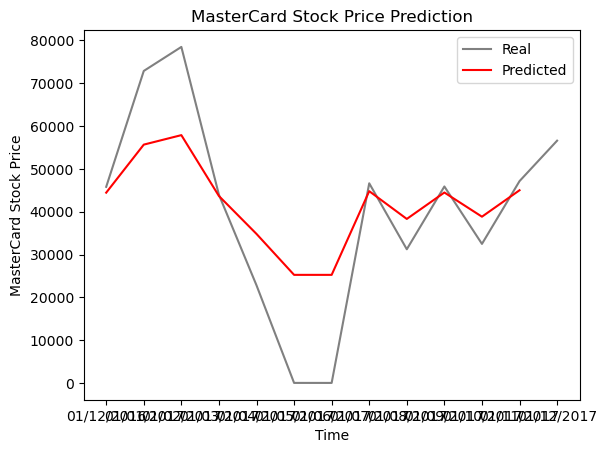

The root mean squared error is 13652.41.


In [46]:
model = Sequential()
model.add(SimpleRNN(256, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu'))
model.add(Dropout(0.4))                
model.add(Dense(units=1, activation = 'linear'))
model.add(Dropout(0.1))

optimizer = Adam(learning_rate=0.001)
early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 6)
callbacks_list = [early]
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

history = model.fit(X_train, y_train, 
    epochs=50, batch_size=20, verbose=2, 
    validation_split = 0.20,
    callbacks = callbacks_list)

predicted_price2 = model.predict(X_test)
predicted_price2 = sc.inverse_transform(predicted_price2)
    
plt.figure(figsize=(20, 10))
plot_predictions(test_set,predicted_price2)

return_rmse(test_set[:-1],predicted_price2)

# ARIMA

We used the auto_arima function, It's a function already implemented in python that finds the best ARIMA model that fits our timeseries data.
ARIMA combines autoregression, differencing and moving average.

We chose to scale the data in order to facilitate the differenciation of the timeseries if needed for the ARIMA model

In [59]:
train_data, test_data = train_test_split(data, test_size=0.045)

sc2 = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc2.fit_transform(train_data)
test_data_scaled = sc2.transform(test_data)

model = pm.auto_arima(train_data_scaled, seasonal=True, m=12, suppress_warnings=True)

print(model.summary())

predictions = model.predict(test_data_scaled.shape[0])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  87.930
Date:                            Wed, 29 Nov 2023   AIC                           -165.860
Time:                                    15:41:49   BIC                           -148.233
Sample:                                         0   HQIC                          -158.767
                                            - 252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2172      0.059      3.685      0.000       0.102       0.333
ma.L1         -0.9756      0.022   

p=1: AutoRegressive (AR) terms  
d=1: Differencing order (Integrated)  
q=1: One Moving Average (MA) terms  
P=1: Seasonal AR order (Seasonal AutoRegressive)  
D=0: Seasonal differencing order  
Q=1: Seasonal MA order  
m=12: Seasonal period (monthly data, so 12 for yearly seasonality)  

In [40]:
pred = sc2.inverse_transform(predictions.reshape(-1,1))

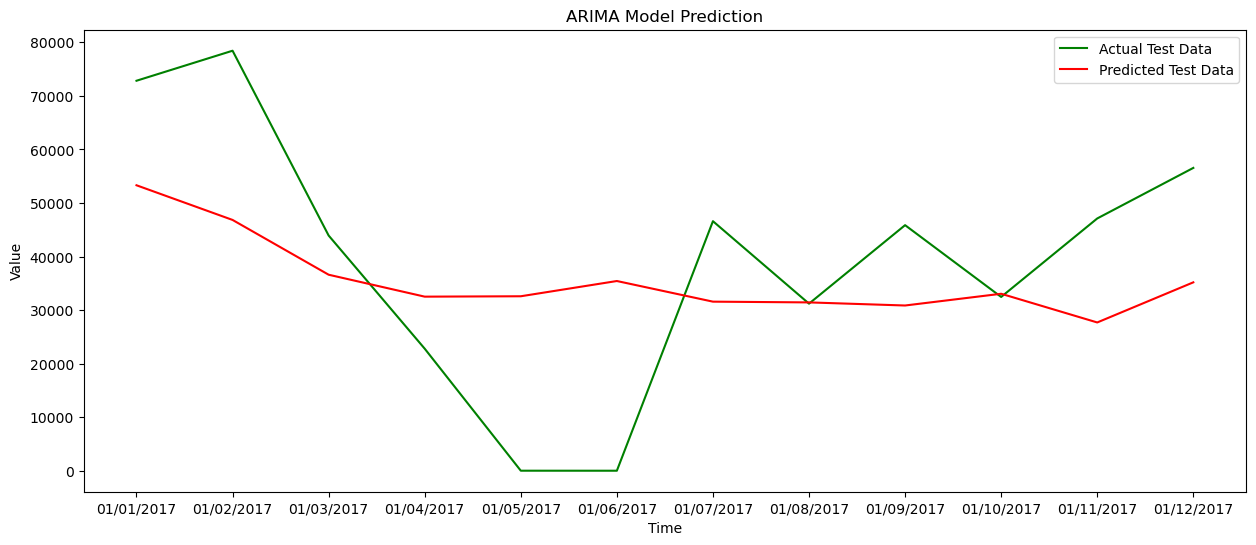

In [41]:
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
plt.plot(test_data.index, pred, label='Predicted Test Data', color='red')
plt.title('ARIMA Model Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [43]:
return_rmse(test_data,pred)

The root mean squared error is 20666.22.


# Conclusion

On remarque dans notre série qu'à partir de la moitié de l'année 2006, le prix s'est diminué ayant une moyenne plus baisse qu'avant, avec des fluctuations plus réduites.  
La série présente une presque saisonnalitér dans chaque année (chaque mois ayant un prix très élevé est suivi par une chute du prix)

Le modèle simpleRNN a montré des performances supérieures par rapport au modèle ARIMA.  
La racine carrée de l'erreur quadratique moyenne est plus basse indiquant une meilleure capacité du modèle RNN à comprendre notre série temporelle.  

Selon ARIMA model, la serie originale n'est pas stationnaire(ce qui évident visuellement en regardant la graphe au début de ce tp puisuqe les oyennes et variances varient au cours du  temps), il faut differencier d'un ordre afin d'atteindre la stationnarité, avec un ordre autoregressive (2 mois consecutifs corrélés) et un ordre MA (erreur).  
Ce modèle est déja optimisé avec Python.

Le meilleur modèle RNN obtenu est relativement simple, en utilisant simpleRNN (short memory only), et 2 couches: couche d'entrées de 256 neurones et couche de sortie avec du dropout pour éviter le sur-apprentissage.  
Pour que le réseaux de neurones soit capables de capter la saisonnalité à long term, on peut substituer le simpleRNN par LSTM(long and short term memory)

le modèle RNN est plus capable a s'adapter à la compléxité de notre série. Cette dernière n'est pas facilement expliqué par la linéarité avec les observations précédentes (AR) ou erreurs précédents (MA) qui est la base du modèle ARIMA 

ADF Statistic: -11.606215893420341
p-value: 2.577341710820297e-21
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}


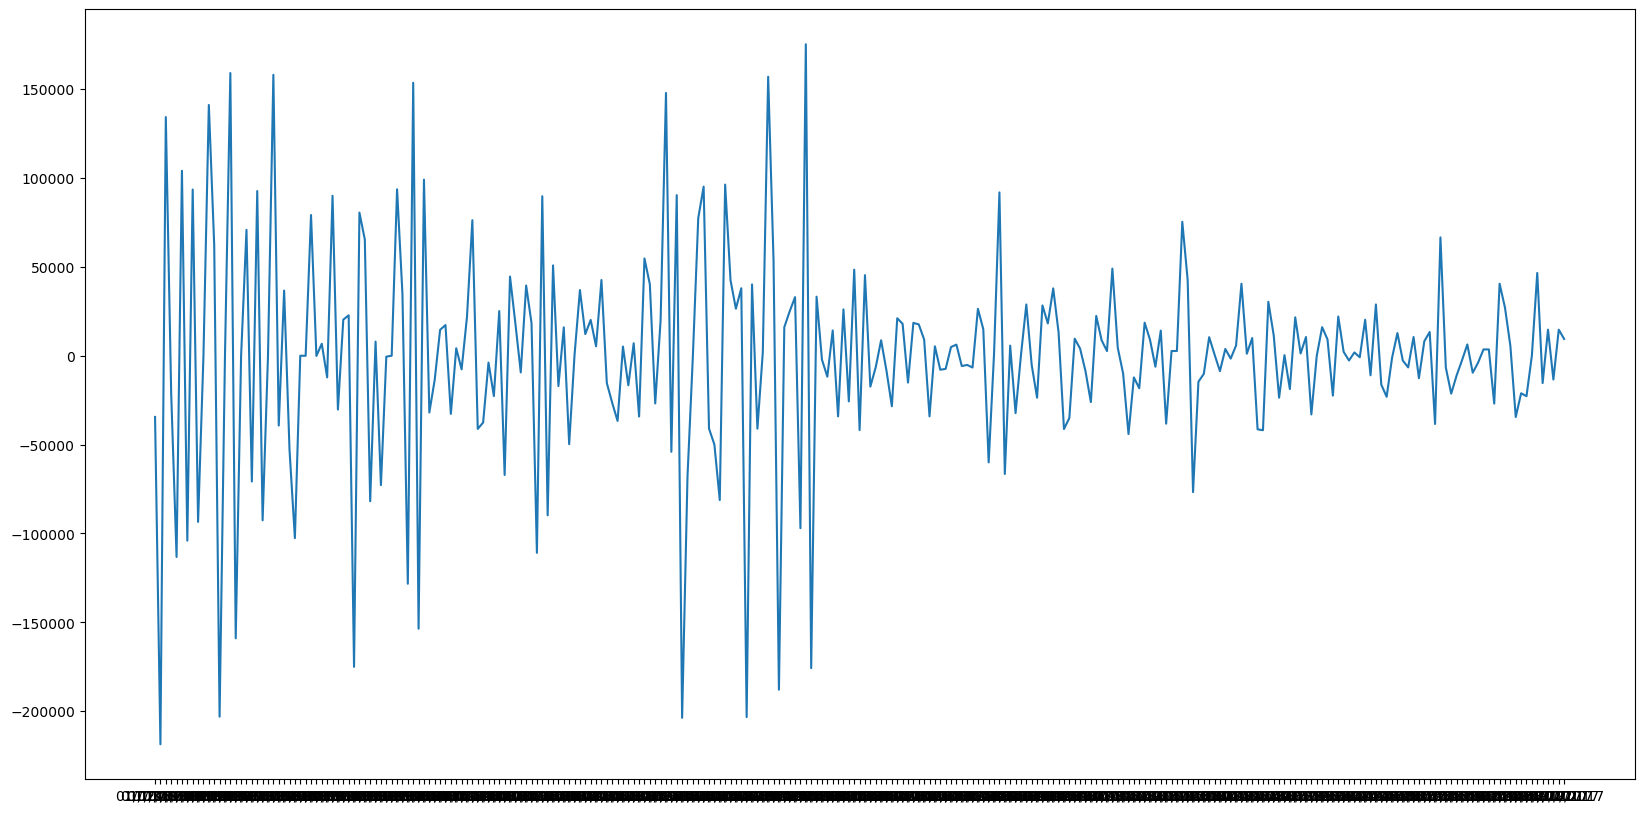

In [30]:
differenced_series = data.diff().dropna()
plt.figure(figsize=(20,10))
plt.plot(differenced_series)

from statsmodels.tsa.stattools import adfuller

result = adfuller(differenced_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

On voit que meme après la differenciation d'ordre 1 suggéré par la fonction auto_arima, la série présente des fluctuations (std) qui diffèrent au cours du temps.